In [170]:
# ! pip install imutils
import argparse
import imutils
import cv2

from os import listdir
import cv2
import sys
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt

import pickle

input_path = '../data/Set1Part0'
output_path = "pikles"
img_size=(30,30,3)


#Read in image files
# images_files = [f for f in listdir(input_path + 'dataset')]
images_files = [f for f in listdir(input_path)]

images_files = images_files[:20]

images = {}

for image_file in images_files:
    images[image_file] = (cv2.imread(input_path + "/" + image_file))
    
sign_or_not = pickle.load(open("sign_or_not_classifier.pkl", 'rb'))

In [171]:
def classify_signs(classifier_model, img_list, confidence):
    # returns 1 if sign, 0 if not
    
    flat_data_arr_ = []
    
    for i in img_list:
        flat_data_arr_.append(cv2.resize(i, [32, 32]).flatten())
    
    flat_data_=np.array(flat_data_arr_)

    df_=pd.DataFrame(flat_data_) #dataframe
    df_['Target']="useless"
    x_=df_.iloc[:,:-1] #input data 
    
    pred = classifier_model.predict_proba(x_)
    
    preds = []
    for i in pred:
        if i[0] >= confidence:
            preds.append(0)
        else:
            preds.append(1)
    return preds

In [11]:
def blue_mask(img):
    
    # img = constrastLimit(img)
    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_blue= np.array([78,158,124])
    upper_blue = np.array([138,255,255])

    mask = cv2.inRange(hsv,lower_blue,upper_blue)
    
    cnt, _ = cv2.findContours(mask, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(mask, cnt, -1, (0,255,0), 3)
    
    return mask
    

def red_mask(img):
    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # mask2 = cv2.inRange(hsv, (80, 70, 130), (255, 255, 255))
    # lower mask (0-10)
    lower_red = np.array([0,50,50])
    upper_red = np.array([12,255,255])
    mask0 = cv2.inRange(hsv, lower_red, upper_red)

    # upper mask (170-180)
    lower_red = np.array([170,50,50])
    upper_red = np.array([182,255,255])
    mask1 = cv2.inRange(hsv, lower_red, upper_red)

    # join my masks
    mask = mask0+mask1
    
    cnt, _ = cv2.findContours(mask, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(mask, cnt, -1, (0,255,0), 3)
    
    return mask

In [172]:
def return_interesting_area_coords(img):
    
    ROIs = []
    
    red_masked = red_mask(img)
    blue_masked = blue_mask(img)

    combine_mask = red_masked + blue_masked

    cnts = cv2.findContours(combine_mask.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(cnts)

    for contour in contours:
        approx = cv2.approxPolyDP(contour, 0.01* cv2.arcLength(contour, True), True)
        x = approx.ravel()[0]
        y = approx.ravel()[1] - 5

        coords = cv2.boundingRect(approx)

        if(cv2.contourArea(approx) > 30):
            # cv2.drawContours(RGB_img, [approx], 0, (0, 0, 255), 5)
            if len(approx) == 3:
                # cv2.putText( RGB_img, "Triangle", (x, y), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 255, 0) )
                ROIs.append(coords)
            elif len(approx) == 4 :
                x, y , w, h = cv2.boundingRect(approx)
                ROIs.append(coords)
                aspectRatio = float(w)/h
#                 if aspectRatio >= 0.95 and aspectRatio < 1.05:
#                     cv2.putText(RGB_img, "square", (x, y), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 255, 0))
#  
#                 else:
#                     cv2.putText(RGB_img, "rectangle", (x, y), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 255, 0))
            else:
                ROIs.append(coords)
                # cv2.putText(RGB_img, "circle", (x, y), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 255, 0))
                
    list_of_sign_imgs = []
    list_of_filtered_ROI = []

    for i in ROIs:
        x,y,w,h = i
        spec_img = cv2.resize(img[y:y+h, x:x+w], (32, 32))
        list_of_sign_imgs.append(spec_img)
    
    preds = classify_signs(sign_or_not, list_of_sign_imgs, 0.631)
    b = np.where(preds)
    coordinates = [e for i, e in enumerate(ROIs) if i in b[0]]
    
    return coordinates

In [161]:
image_to_test = (images[images_files[5]])
coordinates = return_interesting_area_coords(image_to_test)
print(coordinates)

[(364, 753, 13, 4), (184, 688, 28, 29)]


In [162]:
tests = []
for i in coordinates:
    x,y,w,h = i
    spec_img = image_to_test[y:y+h, x:x+w]
    tests.append(spec_img)

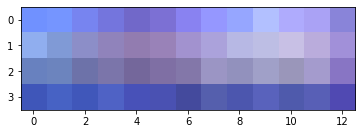

In [167]:
plt.imshow(tests[0])

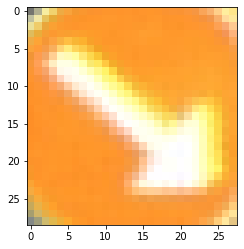

In [168]:
plt.imshow(tests[1])

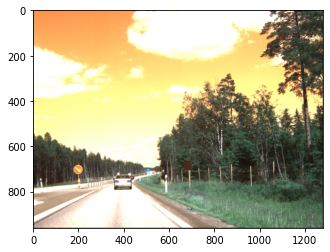

In [169]:
plt.imshow(image_to_test)